# Here we will do more advanced visualizations, working up to Bokeh, of the previously-pulled Twitter data

you should already have a pickle file of the tweets dataframe as extracted from archive.org data 
in 1_import_data.ipynb and 2_analyze_csv_files.ipynb


In [1]:
# import all the necessary libraries

import pandas as pd 
import pickle
import numpy as np
import csv
import json
from sklearn import preprocessing
import matplotlib as mpl
import pylab as plt

# !pip install pycountry-convert
import pycountry_convert as pcountry

# again, geopandas is a tricky library and acts up sometimes.  
# you may need to troubleshoot one day when it worked the 
# previous day.  Try uninstalling and reinstalling with conda-forge for best chance of success.

#! conda install -c conda-forge geopandas
import descartes
import geopandas



In [2]:
# here we again load the pickle file - get this file name from the 2_analzye_csv_files.ipynb file

latest_pickle_file = 'tweets_dataframe.202105111550.pickle'

# uncomment this line to SAVE the dataframe to pickle file
#tweets.to_pickle(latest_pickle_file)

# uncomment this line to LOAD the dataframe from pickle file
tweets = pd.read_pickle(latest_pickle_file)

# Exploring data
let's see what a single country tweets per hour looks like
we can figure out what if anything is in there to see

In [3]:
# define a function that converts the UTC hour to local hour in each tweet
# future improvement - better account for multiple timezones in a single country
def get_country_tweets_per_local_hour(two_letter_country_code, tweets, normalize=True):
    """converts the UTC hour to local hour in each tweet"""

    # select data based on that country code
    tweets_local = tweets[tweets['cc']==country_to_plot.upper()]

    # now plot that country's data by number of tweets per local hour of day
    if (not len(tweets_local) > 0):
        print("no data to plot")
    else:
        try:
            # use the groupby command to count tweets per hour, no matter the day
            t1 = tweets_local.groupby([tweets_local.local_hour])['id'].count()

            if (normalize):
                t1 = t1.transform(lambda x: (x/x.max()))

            print(t1.head())
            print(t1.describe())

            return t1

        except:
            print("An error occured")
            return None


local_hour
0.0    0.138614
1.0    0.069307
5.0    0.069307
6.0    0.138614
7.0    0.207921
Name: id, dtype: float64
count    20.000000
mean      0.351485
std       0.235190
min       0.069307
25%       0.207921
50%       0.311881
75%       0.415842
max       1.000000
Name: id, dtype: float64


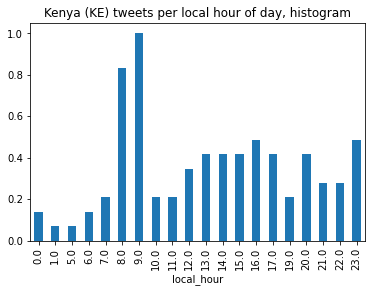

In [4]:
# let's test that function by seeing if we can plot one country at a time

# PICK A COUNTRY HERE with two-letter country code 
# (for codes, see https://www.iban.com/country-codes)
country_to_plot="KE"

# get country name for the title
country_name = pcountry.country_alpha2_to_country_name(country_to_plot.upper())

# now let's run that single country 
tweets_to_plot = get_country_tweets_per_local_hour(country_to_plot, tweets, normalize=True)

# and plot it
title_text = country_name + " (" + country_to_plot + ") " + "tweets per local hour of day, histogram"
ax = tweets_to_plot.plot.bar(title=title_text)
fig_test = ax.get_figure()
#fig_test.savefig("tweets_by_localhour_for_" + country_to_plot + ".png")  


# Now all countries
Now let's try to manipulate the whole dataframe in a way where we can see meaningful data
for all countries

In [5]:
# let's get a num tweets per local hour for all countries

# first get the total set of countries avaialable
country_codes = tweets['cc'].unique()

# then we need to pull data and group num tweets (we'll use 'id') for each country
# and store it in a 2d array
tw_by_cc_and_localhour = []
tw_by_cc_and_utc_hour = []
for cc in country_codes:
    tw_by_cc = tweets[tweets['cc']==cc.upper()]
    t1 = tw_by_cc.groupby([tw_by_cc.local_hour])['id'].count()
    t2 = tw_by_cc.groupby([tw_by_cc.hour])['id'].count()

    tw_by_cc_and_localhour.append(t1)
    tw_by_cc_and_utc_hour.append(t2)

#print(len(tw_by_cc_and_localhour))
#print(tw_by_cc_and_localhour[0])
#print(len(tw_by_cc_and_utc_hour))
#print(tw_by_cc_and_utc_hour[0])

178
local_hour
0.0     2443
1.0     3365
2.0      560
3.0      672
4.0      511
5.0      525
6.0      777
7.0     1120
8.0     1715
9.0     2198
10.0    2772
11.0    2877
12.0    3255
13.0    3290
14.0    3220
15.0    3255
16.0    2639
17.0    3234
18.0    3115
19.0    3514
20.0    4585
21.0    3633
22.0    3381
23.0    2842
Name: id, dtype: int64
178
hour
0     3972
1     3795
2     3815
3     3323
4     2526
5     1991
6     1581
7      561
8      750
9      503
10     628
11     911
12    1305
13    1936
14    2510
15    2878
16    3062
17    3196
18    3531
19    3321
20    3244
21    3241
22    3336
23    3582
Name: id, dtype: int64


# Normalizing the data
Given the wide variance in absolute num of tweets per country, let's normalize each country
to its own tweets per hour

In [6]:
# now let's make a normalized set; where each country is normalized to itself
# there may be a better way to run this operation without iterating, but 
# it was elusive.  so let's iterate and go through each country

# first local hour
tw_by_cc_and_localhour_df = pd.DataFrame(tw_by_cc_and_localhour)
tw_by_cc_and_localhour_df = tw_by_cc_and_localhour_df.fillna(0)
tw_by_cc_and_localhour_normalized = []

i = 0 
for index, row in tw_by_cc_and_localhour_df.iterrows():
    # normalize
    row = [float(r)/max(row) for r in row]

    #print(row)
    tw_by_cc_and_localhour_normalized.append(row)
    i += 1

# and again for utc hour
tw_by_cc_and_utc_hour_df = pd.DataFrame(tw_by_cc_and_utc_hour)
tw_by_cc_and_utc_hour_df = tw_by_cc_and_utc_hour_df.fillna(0)
tw_by_cc_and_utc_hour_normalized = []

i = 0 
for index, row in tw_by_cc_and_utc_hour_df.iterrows():
    # normalize
    row = [float(r)/max(row) for r in row]

    #print(row)
    tw_by_cc_and_utc_hour_normalized.append(row)
    i += 1

#print(tw_by_cc_and_localhour_normalized[0])
#print(tw_by_cc_and_utc_hour_normalized[0])

[0.5328244274809161, 0.7339149400218102, 0.12213740458015267, 0.1465648854961832, 0.11145038167938931, 0.11450381679389313, 0.16946564885496182, 0.24427480916030533, 0.37404580152671757, 0.47938931297709925, 0.6045801526717557, 0.6274809160305344, 0.7099236641221374, 0.7175572519083969, 0.7022900763358778, 0.7099236641221374, 0.5755725190839694, 0.7053435114503817, 0.6793893129770993, 0.766412213740458, 1.0, 0.7923664122137405, 0.7374045801526717, 0.6198473282442748]
[1.0, 0.9554380664652568, 0.9604733131923464, 0.8366062437059416, 0.6359516616314199, 0.5012588116817724, 0.39803625377643503, 0.14123867069486404, 0.18882175226586104, 0.12663645518630412, 0.1581067472306143, 0.22935548841893252, 0.3285498489425982, 0.4874118831822759, 0.6319234642497482, 0.7245720040281974, 0.770896273917422, 0.8046324269889225, 0.8889728096676737, 0.8361027190332326, 0.8167170191339376, 0.8159617321248741, 0.8398791540785498, 0.9018126888217523]


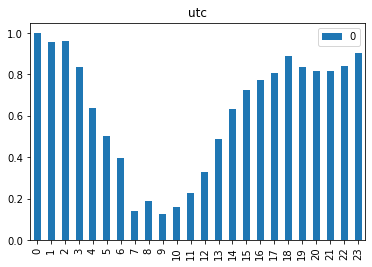

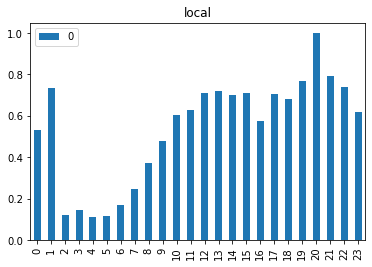

In [7]:
# let's test this out by printing it with UTC time and local time and taking a look

# we can just pick the first country ([0]) to make sure we can see the timezone shift
ax1 = pd.DataFrame(tw_by_cc_and_utc_hour_normalized[0]).plot.bar(title="utc")
fig1 = ax1.get_figure()

ax2 = pd.DataFrame(tw_by_cc_and_localhour_normalized[0]).plot.bar(title="local")
fig2 = ax2.get_figure()


### Preparations for Plotting a World Map ###

First, download and unzip a map shapefile for use in geopandas
Getting from public location at "Natural Earth" website:

https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/ 

and store that locally at ./shapefiles/ne_110m_admin_0_countries.shp


In [8]:
# Read shapefile using Geopandas
# this stores the actual shapes of all the countries which we'll keep in the geo dataframe 'gdf'
shapefile = 'shapefiles\\ne_110m_admin_0_countries.shp'  # change the slashes per windows or linux
gdf = geopandas.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])


In [9]:
# Within the new gdf, we'll need to convert the 3-letter country code
# to a 2-letter country code to make it easier for merging with twitter data

# turns out, no great way to do this reliably without iterating
gdf = gdf.assign(cc='--')   # allocate space
rows_updated = 0

for i, row in gdf.iterrows():
    try:
        try:
            # get the country code column
            #print(row['country_code'])
            ccode = pcountry.country_alpha3_to_country_alpha2(row['country_code'])
            #print(ccode)
            
            # add the country code column
            gdf.at[i,'cc'] = ccode.upper()
            rows_updated += 1
        except:
            pass
    except:
        print("error " + row['name'] + " " + row['iso_a3'])

print(gdf.head(8))
print("rows updated: {}".format(rows_updated))

                       country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   
5                   Kazakhstan          KAZ   
6                   Uzbekistan          UZB   
7             Papua New Guinea          PNG   

                                            geometry  cc  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  FJ  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  TZ  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  --  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  CA  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  US  
5  POLYGON ((87.35997 49.21498, 86.59878 48.54918...  KZ  
6  POLYGON ((55.96819 41.30864, 55.92892 44.99586...  UZ  
7  MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...  PG  
rows updated: 170


# Plot peak hour of twitter activity 


In [10]:
# make a df where country is paired with the max values of row are at following columns
# this uses the idxmax function 
maxValue_local = pd.DataFrame(tw_by_cc_and_localhour_normalized).idxmax(axis=1)
maxValue_utc   = pd.DataFrame(tw_by_cc_and_utc_hour_normalized).idxmax(axis=1)

# make a temporary dataframe for merging into gdf
df_to_merge = pd.DataFrame( zip(country_codes, maxValue_local, maxValue_utc), \
                            columns = ['cc', 'peak_local_hour', 'peak_utc_hour'])


In [11]:
# now merge that in to the gdf on two-letter country code
# use left merge to avoid dropping countries with no data from the map drawing
gdf = gdf.merge(df_to_merge, how='left', on='cc')

# knowing that we're going to want countries with no data to fade into bakground, going to set 
# na values to 12 (noon) which will be white, like the background
gdf = gdf.fillna({'peak_local_hour': 12, 'peak_utc_hour': 12})

print(gdf.head())

                       country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  cc  peak_local_hour  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  FJ              9.0   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  TZ              9.0   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  --             12.0   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  CA             22.0   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  US             20.0   

   peak_utc_hour  
0           21.0  
1            6.0  
2           12.0  
3            1.0  
4            0.0  


Finally time to make our first map

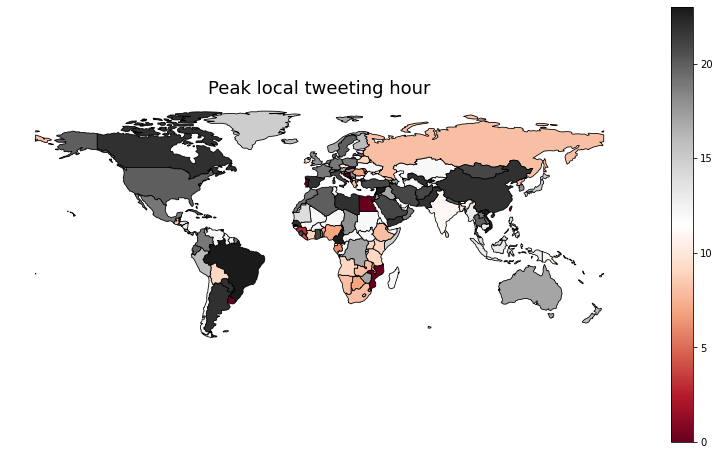

In [12]:
# Create a map using geopandas
# it'll be darker colors for night time, red in the morning and gray at late night
fig1, ax1 = plt.subplots(figsize=(14, 8))
gdf.plot(ax=ax1, column='peak_local_hour', cmap='RdGy', linewidth=0.8, edgecolor='black', legend=True)
ax1.axis('off')
ax1.set_title('Peak local tweeting hour', fontsize=18)
fig1.savefig("world_peak_tweeting_hour.png")



# Plot peak UTC hour of activity

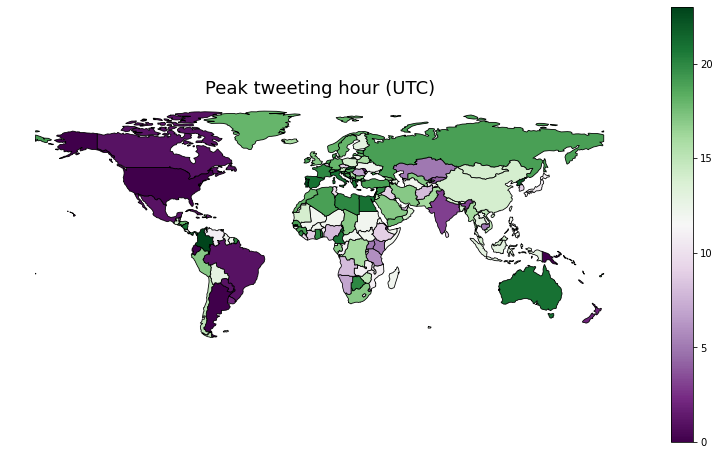

In [13]:
# we can do a similar thing for UTC hour, which should theoretically look like a smooth transition
# from west to east if people are the same in each country, in terms of staying up and tweeting all at once
# at a particular hour
fig2, ax2 = plt.subplots(figsize=(14, 8))
gdf.plot(ax=ax2, column='peak_utc_hour', cmap='PRGn', linewidth=0.8, edgecolor='black', legend=True)
ax2.axis('off')
ax2.set_title('Peak tweeting hour (UTC)', fontsize=18)
fig2.savefig("world_peak_tweeting_hour_utc.png")

# BOKEH interactive plots
Bokeh allows for interactive plots
This can draw a user in to the data to better explore it.
BOKEH can be tricky depending on your OS, coding environment, ipynb vs py file, etc. 
Making matters worse, some of the bokeh adaptations are buggy, so it's tough to tell
where the problem lies.  

For this model, the first few blocks will be adapated to work with the ipynb format.
After that, more interactive features failed to render, and the most consistent cross-platform method
was to save the geo dataframe out as a pickle file, then reload it in a separate .py python file,
and serve bokeh from there.


In [14]:
# now let's try BOKEH

from bokeh.io import output_file, show, save, output_notebook, export_png, push_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Slider
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh import palettes
from bokeh.layouts import column
from bokeh.resources import INLINE
import yaml
#!pip install jupyter_bokeh

#!pip install colorcet
import colorcet

#!pip install panel
import panel as pn
import panel.widgets as pnw

pn.extension()

output_notebook(resources=INLINE)
#output_file("temp.html")


Loading BokehJS ...

In [15]:
# this function will modify whatver gdf at the time into a format good for bokeh plotting
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

In [16]:
# let's get the appropriate geo source for bokeh plots and declare palette
geosource = get_geodatasource(gdf)

palette = palettes.cividis(12) + palettes.grey(12)[::-1]  # white in the middle, darker towards night
#palette = palettes.brewer['Greens'][6]
#palette = colorcet.fire

print(gdf.head())
print(geosource)

# this is the data column we'll represent by colormap
column_name = 'peak_local_hour'
vals = gdf[column_name]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = vals.min(), high = vals.max())
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20, 
                        location=(0,0), orientation='horizontal')

# add some fun tools
tools = 'wheel_zoom,pan,reset'
p = figure(title = column_name, plot_height=400 , plot_width=850, toolbar_location='right', tools=tools)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure
p.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
            fill_color={'field' :column_name , 'transform': color_mapper})

# Add the HoverTool to the figure
country_hover = HoverTool()
country_hover.tooltips = [('Country ', '@country' + ' (' + '@cc' + ')'), ('pk hour ', '@peak_local_hour' + ':00')]
p.add_tools(country_hover)

# Specify figure layout.
p.add_layout(color_bar, 'below')

# pick to save as html or to show (but not both or bookeh will get mad)
#save(p, filename="map.html")
show(p)

                       country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  cc  peak_local_hour  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  FJ              9.0   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  TZ              9.0   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  --             12.0   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  CA             22.0   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  US             20.0   

   peak_utc_hour  
0           21.0  
1            6.0  
2           12.0  
3            1.0  
4            0.0  
GeoJSONDataSource(id='1003', ...)


### Interactive Time Slider
a better way to draw an audience in will be to allow them to shift the hour at will
and see at what point each country is at, normalized to itself, in terms of its peak twitter activity
we'll keep this as UTC times and we'll need to load in all 24 hours
of normalized twitter usage into the gdf table so we can show one hour at a time on demand

In [19]:
# let's recast the temporary merging dataframe to get all the hoursof the day
df_to_merge = pd.DataFrame( tw_by_cc_and_utc_hour_normalized )
df_to_merge['cc'] = country_codes

# it's neater to have cc as 1st column
first_col = df_to_merge.pop('cc')       
df_to_merge.insert(0, 'cc', first_col)

# cast column names as strings
# this avoids problems in the future by conerting col names 0,1,2... to '0','1','2',...
df_to_merge.columns = df_to_merge.columns.astype(str)

print(df_to_merge.head())

   cc         0         1         2         3         4         5         6  \
0  US  1.000000  0.955438  0.960473  0.836606  0.635952  0.501259  0.398036   
1  IN  0.264938  0.521984  0.857948  1.000000  0.863585  0.770011  0.613303   
2  TR  0.058637  0.071315  0.095087  0.196513  0.285261  0.386688  0.374010   
3  KE  0.014493  0.101449  0.159420  0.521739  0.826087  1.000000  0.666667   
4  IT  0.188406  0.024155  0.043478  0.067633  0.140097  0.231884  0.260870   

          7         8  ...        14        15        16        17        18  \
0  0.141239  0.188822  ...  0.631923  0.724572  0.770896  0.804632  0.888973   
1  0.258174  0.505073  ...  0.586246  0.547914  0.595265  0.443067  0.354002   
2  0.353407  0.657686  ...  0.546751  0.767036  0.917591  0.938193  0.947702   
3  0.304348  0.449275  ...  0.173913  0.188406  0.405797  0.521739  0.217391   
4  0.251208  0.599034  ...  0.338164  0.357488  0.618357  0.657005  0.531401   

         19        20        21        22   

In [20]:
# now let's merge in all 24 hours of normalized utc-hour tweets data for each country
gdf2 = gdf.merge(df_to_merge, how='left', on='cc')

# geopandas doesn't let you fillna on the whole thing so we'll backwards iterate 
# over the last 24 columns and fill nans with 0 (no tweets)
end_index = gdf2.shape[1]-1
for index in range(end_index, end_index-24, -1):
    gdf2.iloc[: , index].fillna(0, inplace=True)

#print(df_to_merge)
#print(gdf.head())
#print(gdf2.head())
#print(gdf2.columns)
#print(gdf2.describe())


### Failed attempts in Jupyter Notebook
The following code pieces are two different attempts to get this to work in
a jupyter notebook platform.  There arae just too many problems that could be at hand, and 
debugging is near impossible.  Version, IDE, platform, open bugs, javascript transforms,
and many other things could be the problems

Ultimately, the only way that removes many of those unknowns is to transition to python file 
and get out of jupyter notebooks, then run a bokeh server from the anaconda prompt to show it 


In [21]:
# first, good time to save, because jupyter is really really tricky to get running
# as interactive bokeh plots
# so a separate python file can load this and serve it
latest_pickle_file = 'bokeh_geodataframe.202105130906.pickle'

# uncomment this line to SAVE the dataframe to pickle file
#gdf2.to_pickle(latest_pickle_file)
#gdf2.to_csv(latest_pickle_file + ".as.csv")

# uncomment this line to LOAD the dataframe from pickle file
#gdf2 = pd.read_pickle(latest_pickle_file)

Now go run the bokeh serve command from anaconda prompt as follows
(change directory as appropriate)

d: <br>
cd Datasci\project_directory\twitter_usage <br>
bokeh serve --show 4_bokeh_map_tweets_by_hour.py <br>

do not run the below code snippets; kept here for a record of 
what does NOT work despite documentation saying it should.


In [22]:
# This method, using traditional slider, does not work in jupyter notebook at this time

### Trying an interactive map using slider and callback ###
def bkapp(doc):

    column_name='0'
    geosource = get_geodatasource(gdf2) # the country outlines and data
    palette = palettes.cividis(100)     # white at zero, darker at max

    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = 0, high = 1)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20, 
                            location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset'
    p2 = figure(title = 'starting', plot_height=400 , plot_width=850, toolbar_location='right', tools=tools)
    p2.xgrid.grid_line_color = None
    p2.ygrid.grid_line_color = None

    #Add patch renderer to figure
    p2.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
                fill_color={'field' :column_name , 'transform': color_mapper})

    def callback(attr, old, new):        
        new_hour_to_plot = str(new)
        p2.fill_color = {'field' :new_hour_to_plot , 'transform': color_mapper}
        push_notebook()
        return

    #Specify figure layout.
    p2.add_layout(color_bar, 'below')

    # Add the HoverTool to the figure
    country_hover = HoverTool()
    country_hover.tooltips = [('country ', '@country' + ' (' + '@cc' + ')')]
    p2.add_tools(country_hover)

    # Add a time slider
    hour_slider = Slider(start=0, end=23, value=3, step=1, name="UTC hour")
    hour_slider.on_change('value', callback)

    #doc.add_root(column(slider, plot))
    from bokeh.layouts import column

    doc.add_root(column(slider, plot))
    #layout = column(hour_slider, p2)

    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
        """, Loader=yaml.FullLoader))

show(bkapp, notebook_handle=True)

#save(app, filename="map.html")
#show(p2)


In [23]:
# This method, using widgets slider, does not work in jupyter notebook at this time
# it was supposed to be better for jupyter, but too many unknowns to debug


def bokeh_plot_map(geodf, column_name='0', title=''):

    geosource = get_geodatasource(geodf)  # the country outlines
    palette = palettes.cividis(100)     # white at zero, darker at max

    vals = geodf[column_name]

    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = vals.min(), high = vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20, 
                            location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset'
    p2 = figure(title = title, plot_height=400 , plot_width=850, toolbar_location='right', tools=tools)
    p2.xgrid.grid_line_color = None
    p2.ygrid.grid_line_color = None

    #Add patch renderer to figure
    p2.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
                fill_color={'field' :column_name , 'transform': color_mapper})

    #Specify figure layout.
    p2.add_layout(color_bar, 'below')

    # Add the HoverTool to the figure
    country_hover = HoverTool()
    country_hover.tooltips = [('country ', '@country' + ' (' + '@cc' + ')')]
    p2.add_tools(country_hover)

    return p2

def map_dash():
    """Map dashboard"""
    
    #from bokeh.models.widgets import DataTable
    map_pane = pn.pane.Bokeh(width=800)
    
    # Add a time slider
    hour_slider = pnw.IntSlider(start=0, end=23, value=8, step=1, name="UTC hour")

    def update_map(event):        
        new_hour_to_plot = str(hour_slider.value)
        map_pane.object = bokeh_plot_map(gdf2, column_name=new_hour_to_plot, title='Current hour: '+ new_hour_to_plot) 
        push_notebook(handle=handle)
        #print(str(hour_slider.value))      
        return

    hour_slider.param.watch( update_map, 'value' )
    hour_slider.param.trigger('value')

    app = pn.Column(hour_slider,map_pane)
    handle = show(app, notebook_handle=True)

    return app, map_pane.object

app, p2 = map_dash()
app

### This displays correctly but does not get to update_map - many potential causes explored ###


NameError: free variable 'handle' referenced before assignment in enclosing scope